## 서비스 목적과 내용
> 저는 논문을 보고 논문의 내용을 뽑아 낼수 있는 모델을 만들고 싶습니다. 그래서 각각의 OCR에 논문 이미지로 테스트를 해보겠습니다.<br/>
> 예상은 논문은 정리가 잘 된 글이기 때문에 어떤 OCR이라도 성능이 좋을거라 예상됩니다.

## 필요한 라이브러리 Import

In [31]:
import os
import io
import keras_ocr
import pytesseract
import matplotlib.pyplot as plt
import matplotlib.image as img
import cv2 
from google.cloud import vision
from PIL import Image, ImageDraw
from pytesseract import Output
from pytesseract import pytesseract as pt
from glob import glob

## 검증용 데이터셋 준비
> ### 논문이미지를 사용했습니다.

In [2]:
fold_path = os.getenv('HOME')+'/aiffel/ocr_python/test/'
images_path = glob(fold_path+'*.png')
images_path

['/aiffel/aiffel/ocr_python/test/3.png',
 '/aiffel/aiffel/ocr_python/test/1.png',
 '/aiffel/aiffel/ocr_python/test/4.png',
 '/aiffel/aiffel/ocr_python/test/2.png']

* 시각화

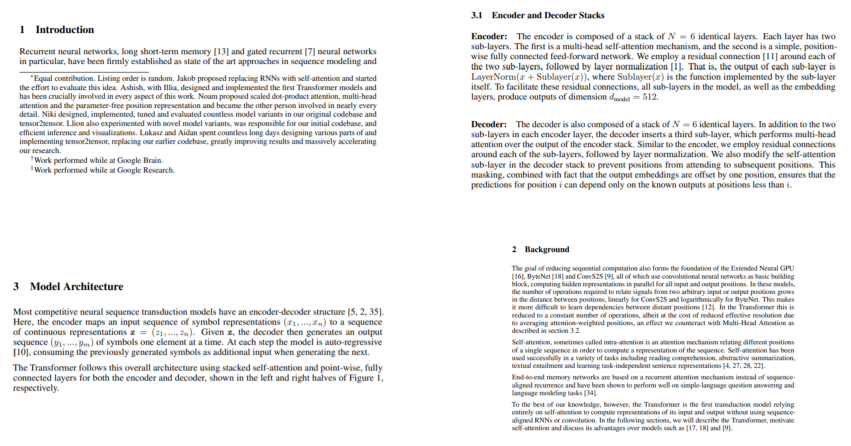

In [3]:
plt.figure(figsize=(15, 8))

for idx, image in enumerate(images_path):
    plt.subplot(2, 2, idx+1)
    im=img.imread(image)
    plt.imshow(im)
    plt.axis('off')

* 잘 나옵니다.

## Google OCR API

In [4]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

In [5]:
def detect_text(path):
    """Detects text in the file."""
    text_list = []
    bound_list = []
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    n = os.path.splitext(path)
    n = os.path.split(n[0])
    name = n[1]
    
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))
        text_list.append(text.description.replace('\n',''))
        vertices = text.bounding_poly
        bound_list.append(vertices)

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    return name, text_list, bound_list

* 텍스트를 찾는 함수를 만들었습니다

In [6]:
def draw_boxes(image, bound_list, color):
    draw = ImageDraw.Draw(image)

    for bound in bound_list:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image

* 시각화를 위해 찾은 텍스트에 박스를 치는 함수를 만들었습니다.

In [7]:
ocr_img = []
ocr_dict = {}

for path in images_path:
    name, text_list, bound_list = detect_text(path)
    ocr_dict[name] = text_list
    image = Image.open(path)
    draw_boxes(image, bound_list, 'red')
    ocr_img.append(image)

Texts:

"1 Introduction
Recurrent neural networks, long short-term memory [13] and gated recurrent [7] neural networks
in particular, have been firmly established as state of the art approaches in sequence modeling and
*Equal contribution. Listing order is random. Jakob proposed replacing RNNS with self-attention and started
the effort to evaluate this idea. Ashish, with Illia, designed and implemented the first Transformer models and
has been crucially involved in every aspect of this work. Noam proposed scaled dot-product attention, multi-head
attention and the parameter-free position representation and became the other person involved in nearly every
detail. Niki designed, implemented, tuned and evaluated countless model variants in our original codebase and
tensor2tensor. Llion also experimented with novel model variants, was responsible for our initial codebase, and
efficient inference and visualizations. Lukasz and Aidan spent countless long days designing various parts of and
im

* 단어를 잘 찾나 확인해 보았습니다. 거의 100% 찾아냅니다.

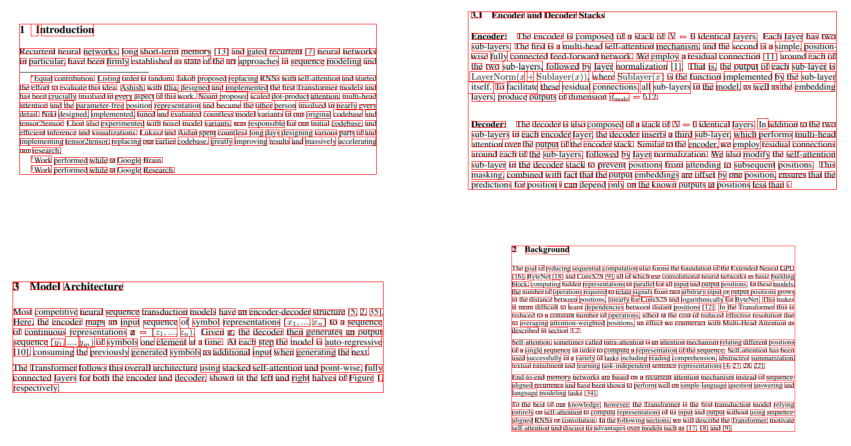

In [13]:
plt.figure(figsize=(15, 8))

for idx, img in enumerate(ocr_img):
    plt.subplot(2, 2, idx+1)
    plt.imshow(img)
    plt.axis('off')

* 시각화를 해보았습니다.<br/> 모든 단어를 찾아낸 모습입니다.

## keras-ocr

In [9]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [11]:
images = [ keras_ocr.tools.read(im) for im in images_path]
prediction_groups = [pipeline.recognize([im]) for im in images_path]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


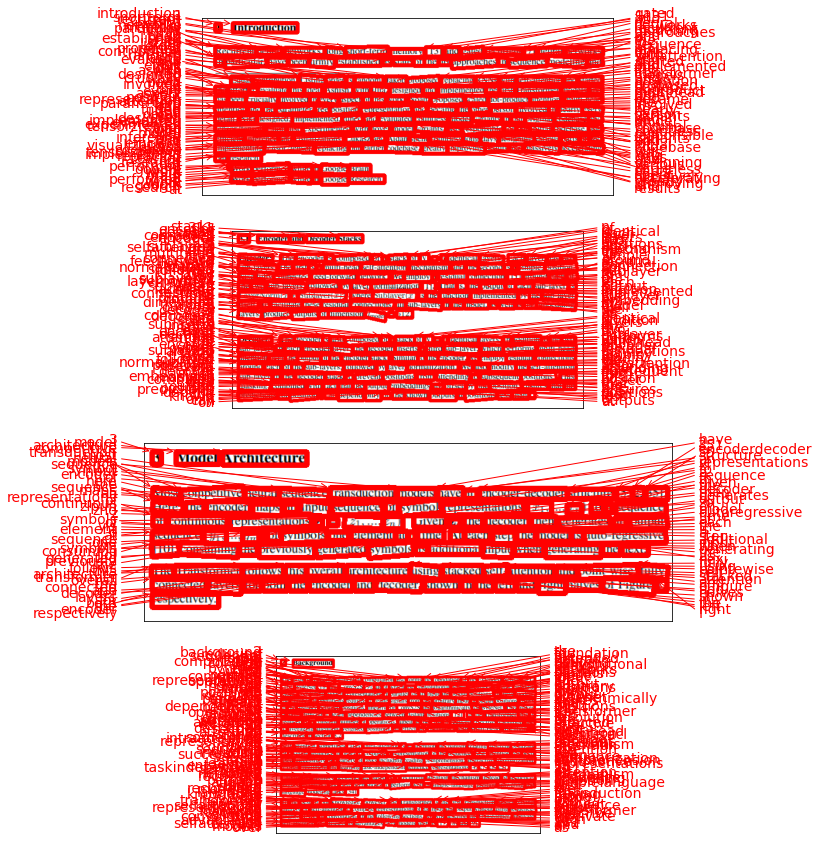

In [12]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(15, 15))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

* 시각화를 해보았습니다. 박스를 잘 쳤나 보면 처음 예상했던데로 구글 OCR과 크게 차이가 없습니다.

## Tesseract

In [35]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path, output_path):
    s = os.path.splitext(image_path)
    s = os.path.split(s[0])
    name = s[1]
    output_path = output_path + name +'/'
    
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    img = cv2.imread(image_path)
    
    d = pt.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    top_level = max(d['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(d['level'])):
        level = d['level'][i]
    
        if level == top_level:
            left = d['left'][i]
            top = d['top'][i]
            width = d['width'][i]
            height = d['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return name, cropped_image_path_list, img


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
output_path = work_dir + '/test/'   

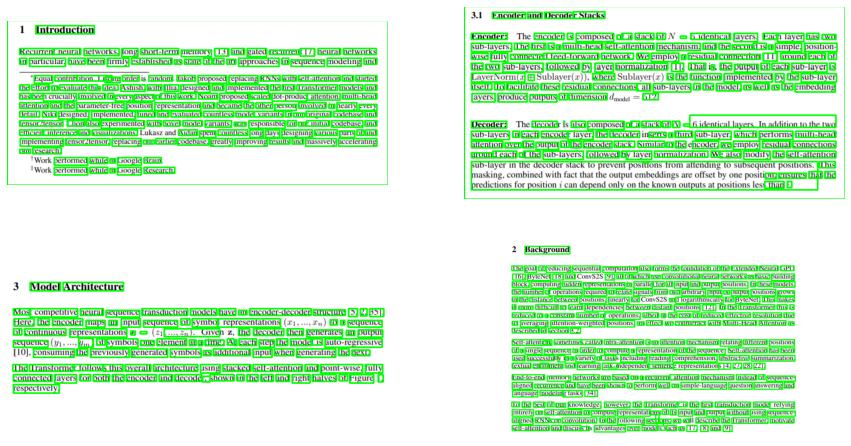

In [38]:
Tesser_dict = {}
img_dict = {}
plt.figure(figsize=(15, 8))

for idx, path in enumerate(images_path):    
    name, cropped_image_path_list, imgs = crop_word_regions(path, output_path)
    Tesser_dict[name] = cropped_image_path_list
    img_dict[name] = imgs
    plt.subplot(2, 2, idx+1)
    plt.imshow(imgs)
    plt.axis('off')

* 시각화를 해보았습니다. 앞에서 했던 예상과 다르게 놓치는 단어가 눈에 보입니다.

## 각각의 OCR 비교

#### Google OCR API

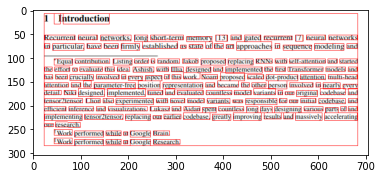

In [45]:
plt.imshow(ocr_img[0])

#### keras-ocr

AxesSubplot(0.125,0.125;0.775x0.755)


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


<Figure size 36000x36000 with 0 Axes>

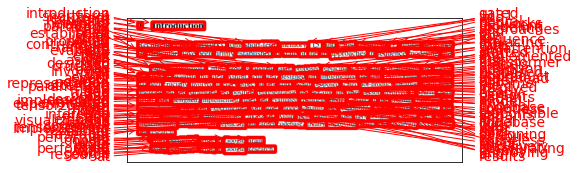

In [50]:
plt.figure(figsize=(500, 500))
a = keras_ocr.tools.drawAnnotations(image=images[0], 
                                    predictions=predictions[0][0])
print(a)

#### Tesseract

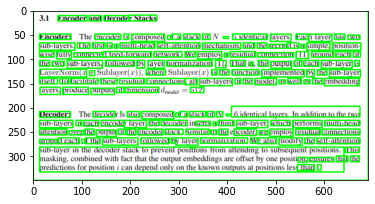

In [49]:
plt.imshow(img_dict['1'])

## 회고
> 논문은 거의 pdf파일로 만들어져있습니다. 그렇기 때문에 이미지로써 글자를 인식하고 읽어내는데 OCR을 활용하기 아주 좋다고 생각했습니다.<br/>
> 그리고 잘 정리되고 손글씨가 없기때문에 거의 대부분의 모델이 좋은 성능을 보일것이라 예상했습니다.<br/>
> 하지만 구글과 케라스는 잘 적용이 되었지만 테서렉트는 몇몇 단어를 인식하지 못한것을 볼수 있었습니다.<br/>
> 시각화 해서 보았을때 구글을 시각화한게 보기 좋아 구글을 많이 사용할것 같습니다.